In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
from helpers import *
%matplotlib inline

# TLDR: Deep Learning performs Cell Nuclei Segmentation

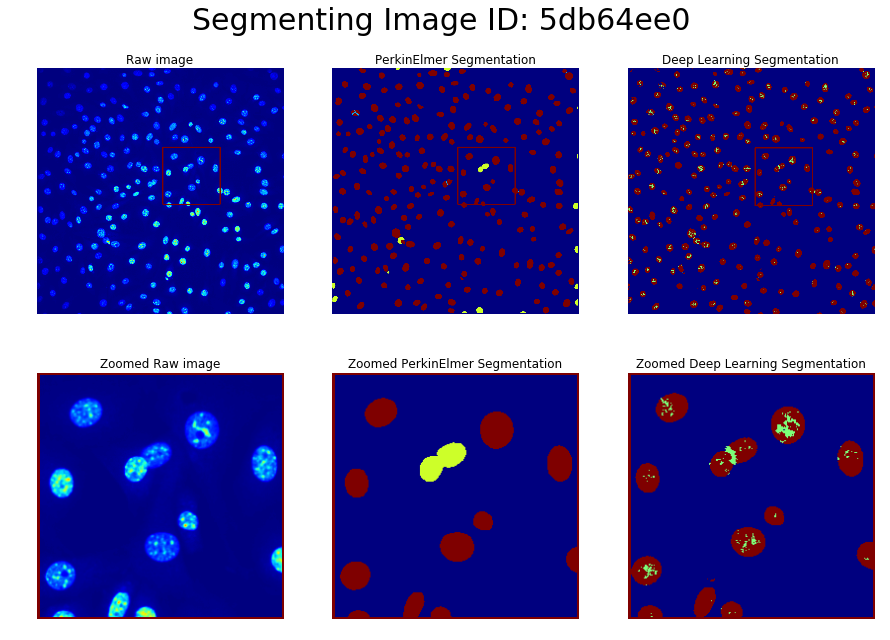

In [2]:
ID = '5db64ee0-fdee-4038-a1da-ad68139c3b2a'
display_zoomed_segmentations(ID)

# Conclusion

Yellow regions are discarded by the PerkinElmer segmentations. Deep Learning is able to correctly identify these regions as shown in the zoomed box.

# Cell Nuclei Segmentation

Cell segmentation is the task of identifying seperate cell nuclei from microscopy images of cells. Some cells are very bright, and other are very faint. Therefore identifying nuclei by thresholding on pixel intensity is bad strategy. Furthermore, cell nuclei often congregate together. Therefore multiple adjacent cells are often misclassified as a single nuclei, when it in fact consists of many nuclei located very close to each other. For these reason, and others not mentioned, it is difficult to correctly classify the exact location of different cell nuclei within microscopy images.

PerkinElmer is a biotechnology company that manufacture microscopes and sell cell nuclei segmentation software. Using a combination of segmentation techniques that use pixel thresholding and the [watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing), they have annotated 3024 cell microscopy images with the nuclei of each cell. The company is able to successfully segment greater than 90% of cells in each assay. However, there are areas where their algorithm performs poorly, which they discard. These are shown below. In the images of the clean segmentations and the discarded segmentations, each pixel colour indicates distinct nuclei regions.

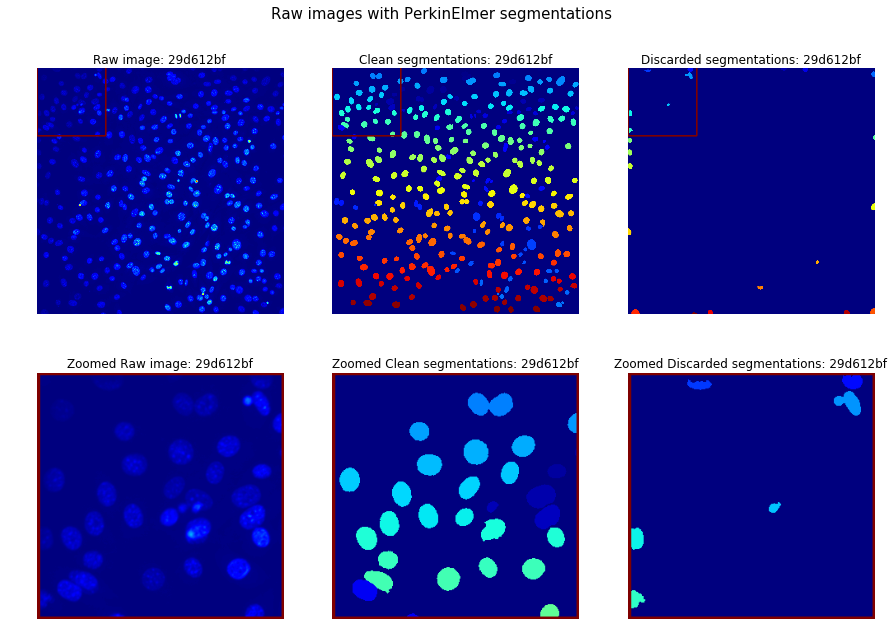

In [3]:
display_example_segmentations()

Drawing inspiration from [DeepCell](https://www.ncbi.nlm.nih.gov/pubmed/27814364) in PLoS Comp. Biol, November 2016. We investigated whether deep learning could automate this process using labels provided to us from PerkinElmer. Our strategy was to train a classifier to classify each pixel as being within a nucleus or part of the background, using a square neighbourhood around the pixel.

We noticed that the areas where the existing segmentation algorithm performed the most poorly were in areas that were between cell nuclei, and in the areas near the edges of the image. To address the first source to error, we decided to include an additional pixel class which indicated whether a pixel was *between two or more cells*. This are the pixels which are situated between closely adjacent cells, that we hypothesised would be the hardest to classify. We generated training data for this class by looking at the clean segmentations. For each pixel, we tested whether there existed more than one cleanly labelled cell in a 5x5 square patch around the pixel. We used this to generate a single image which consisted of pixels from the 4 following distinct classes. 
* Background pixels: pixels in the background
* Between pixels: pixels that were between two or more cells
* Clean pixels: pixels that were part of cleanly segmented regions
* Discarded pixels: pixels that were part of discarded regions

The **dark blue colour signifies background regions**, **yellow signifies discarded regions**, **light blue signifies between cells regions** and **red signifed cleanly segmented cell regions**.

# Display training data

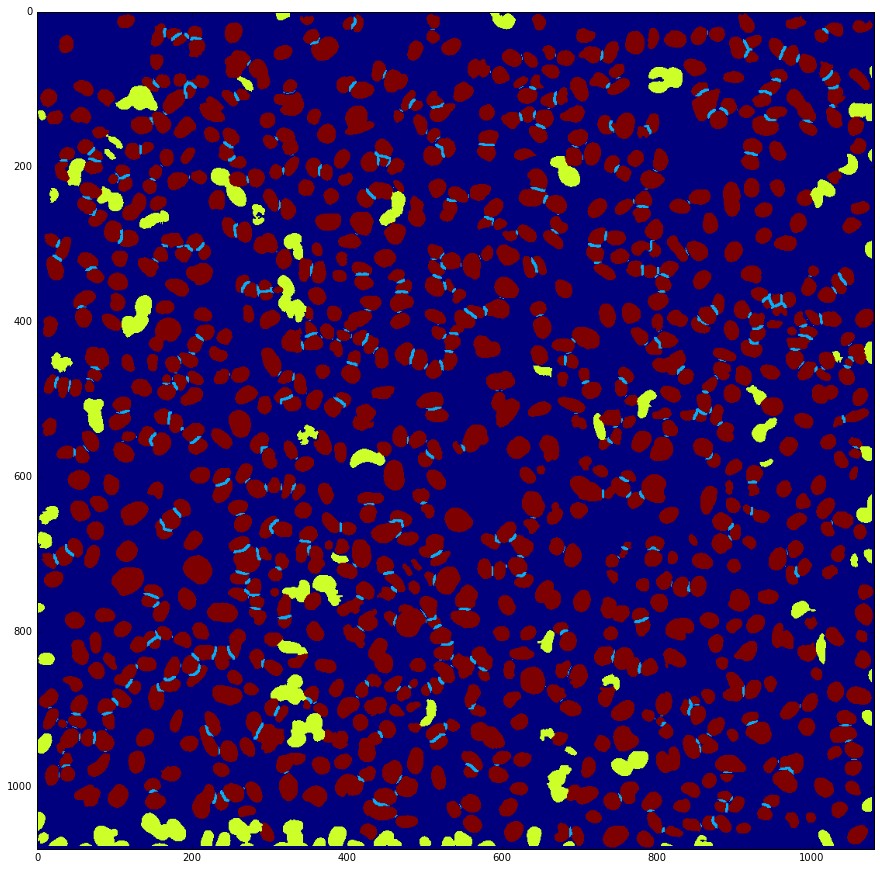

In [4]:
display_random_border_image()

# Generating Training Data

Since by definition the discarded regions are the regions where the PerkinElmer segmenter performs poorly, we did not want to include these pixels in our classifier. Furthermore, we *did not want to include any pixel whose neighbourhood overlapped with a discard region*. Our training data consisted of 11x11 pixel patches of the image that were chosen such that its 11x11 pixel neighbourhood did not overlap with any discarded region. We maintained balanced classes. We sampled from each class the number of instances equal to the class with the lowest number of pixels. Invariably, this was the between pixel class.

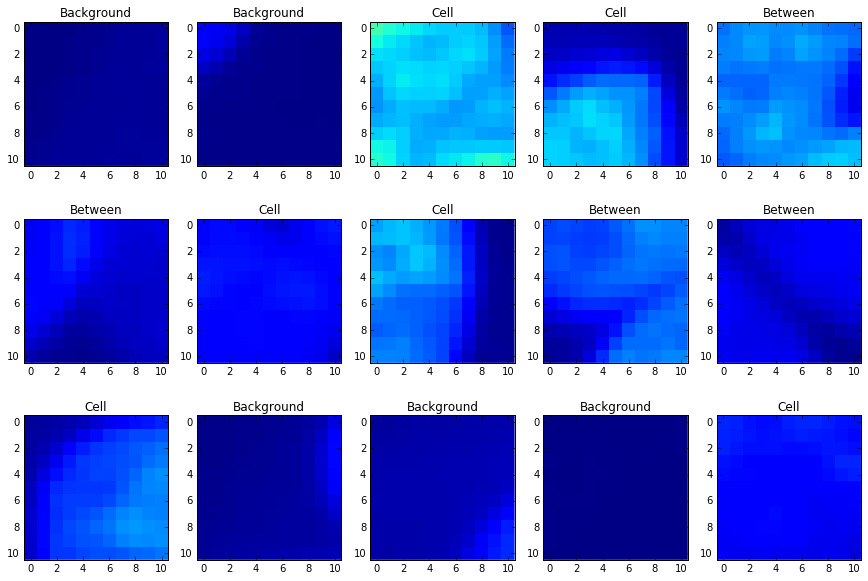

In [2]:
patches = pickle.load(open('patches/oldpatches/patches_51.py','rb'))
display_random_patches(patches)

# Training a classifier

We then trained a convolutional neural network with 3 convolutional layers and 2 fully connected layers. These convolutional layers had 128, 128 and 64 filters, and filter sizes of 5x5, 5x5, and 3x3 respectively. The fully connected layers both had 1000 hidden units. We used the default ReLU activation function between each layer and the ADAM Stochastic optimisation algorithm. We included dropout with keep probability equal to 0.5 after each layer to prevent overfitting. The idea of using stacked encoders with small filter sizes originates [here](https://arxiv.org/pdf/1409.1556.pdf), and the architecture is similar to that commonly use on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [ ]:
clf = Classifier(params = {'epochs':100,'display_step':1,'batch_size':500,'learning_rate': 0.001,'patches_number': 51,'models_dir': 'models/'})
clf.train()

Now display statistics. We can see that the test accuracy plateaus at approximately 0.95% and the models starts to overfit around epoch 30.

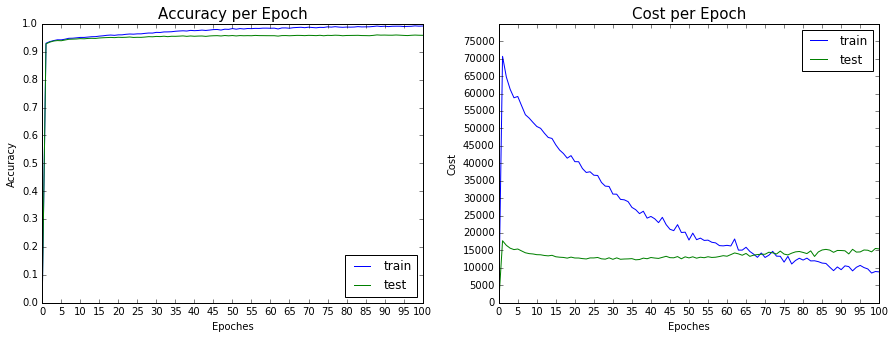

In [17]:
display_clf_statistics(clf)
plt.show()

# Segmenting the Image

Image nuclei segmentation can be reduced to a classification task. Define a pixel patch as the 11x11 neighbourhood square patch around an image. Given a new image, each pixel along with its pixel patch is fed into our deep model. Each pixel is then given a class based on which class is most highly activated (background pixel, between pixel and cell pixel. Once these classes have been attributed, the task of cell segmentation reduces to choosing all the pixels of a specific class.

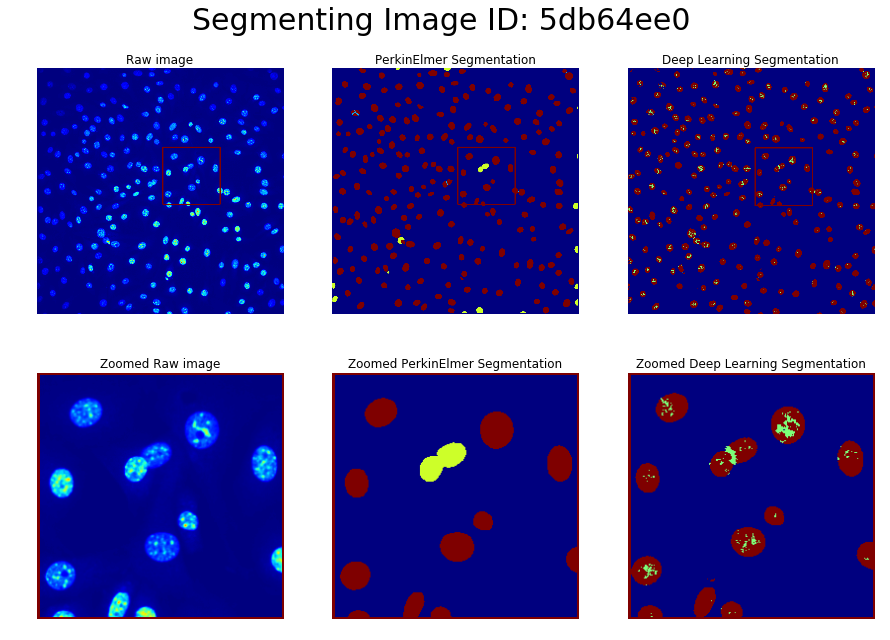

In [2]:
ID = '5db64ee0-fdee-4038-a1da-ad68139c3b2a'
display_zoomed_segmentations(ID)

# Conclusion: Deep learning performs Cell Nuclei Segmentation

We see that deep learning is able to segment the regions that were discarded by the PerkinElmer segmentation algorithm. This are the areas that are colour in yellow. It seems that our model overcalls the between pixel class, which is an area of improvement and future work. A reason for this could be because we provided all three classes in equal measure to the model, when in fact the between cell class is heavily under-represented in the raw data. Below are the segmentation of 5 randomly chosen images.

In [ ]:
segments = [Segmenter('oldmodels/patches31-ep97-lr0.001', ID) for ID in np.random.choice(image_IDs, 5)]

Now display the segmentations:

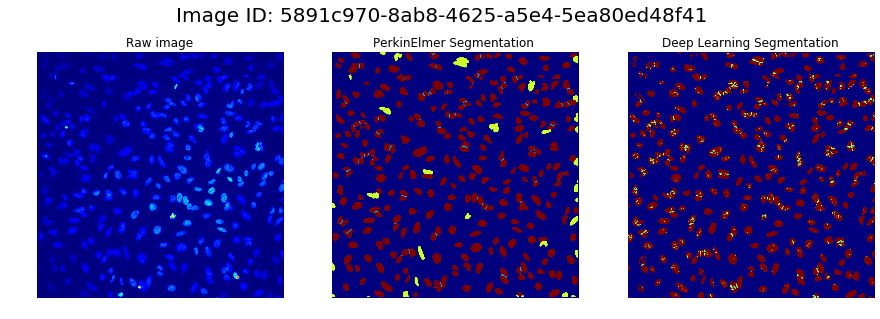

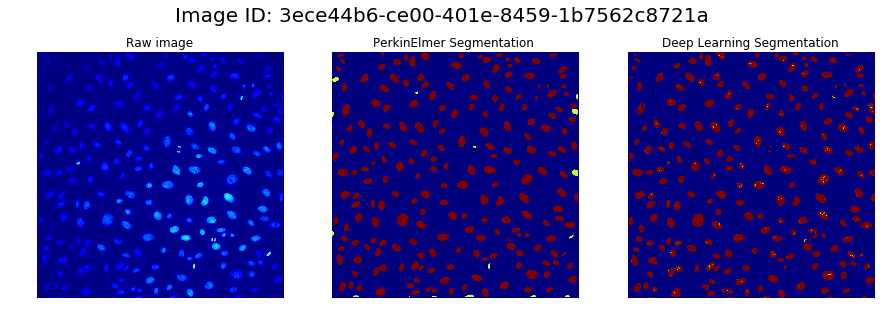

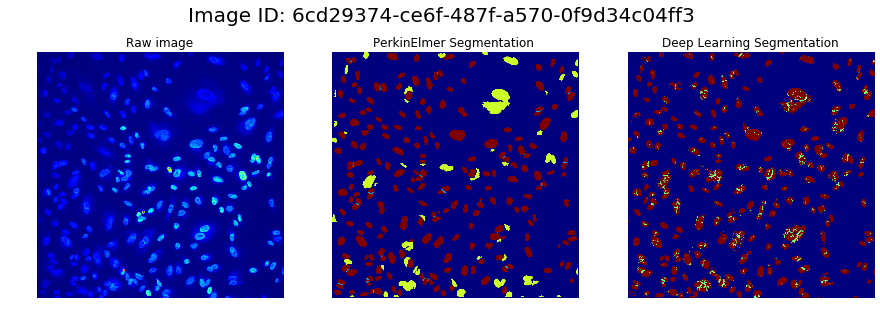

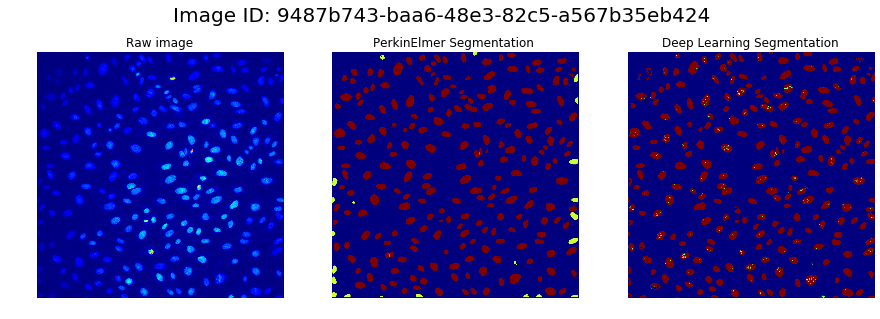

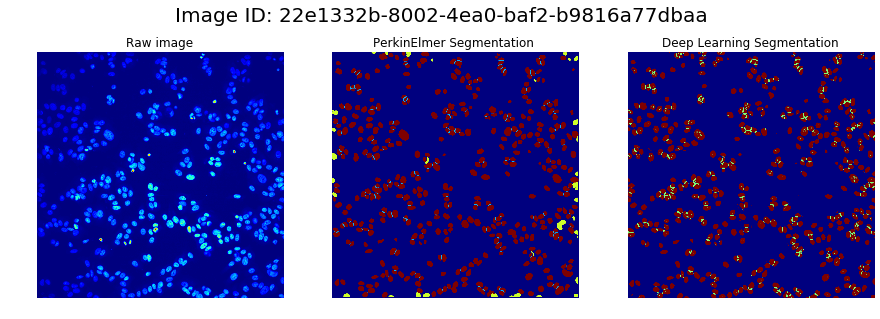

In [19]:
for seg in segments:
    seg.display()